# DeVISE
Paper: [Frome et al. 2013](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/41473.pdf)

In [1]:
%matplotlib inline

In [2]:
from fastai.conv_learner import *
import fastText as ft
import torchvision.transforms as transforms
from fastai.io import get_data

In [3]:
torch.backends.cudnn.benchmark=True

## Data
### Imagenet data

In [4]:
PATH = Path('data/imagenet')
TMP_PATH = PATH/'tmp'
TRANS_PATH = Path('data/translate/word_vectors')
PATH_TRAIN = PATH/'train'

In [5]:
sz = 224

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # values for imagenet

tfms = transforms.Compose([
    transforms.RandomSizedCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

In [7]:
arch = resnet50

In [8]:
ttfms, vtfms = tfms_from_model(arch, sz, transforms_side_on, max_zoom=1.1)

### Wordvectors

In [9]:
wordvectors = ft.load_model(str((TRANS_PATH/'wiki.en.bin')))

In [10]:
wordvectors.get_word_vector("house").shape

(300,)

#### Correlation

In [11]:
np.corrcoef(wordvectors.get_word_vector("house"), wordvectors.get_word_vector("building"))

array([[1.     , 0.46162],
       [0.46162, 1.     ]])

In [12]:
np.corrcoef(wordvectors.get_word_vector("house"), wordvectors.get_word_vector("ant"))

array([[1.     , 0.05766],
       [0.05766, 1.     ]])

**The word vectors of things that are similar are correlated (house, building) and those of words that are not similar are not correlated (house, ant).**

### Map imagenet classes to word vectors

In [13]:
words = wordvectors.get_words(include_freq=True)

In [14]:
word_dict = {k:v for k,v in zip(*words)}

In [15]:
words = sorted(word_dict.keys(), key=lambda x: word_dict[x])

In [16]:
len(words)

2519370

**List of the names of the 1000 imagenet classes:**

In [17]:
CLASSES_FN = 'imagenet_class_index.json'

In [18]:
get_data(f'http://files.fast.ai/models/{CLASSES_FN}', TMP_PATH/CLASSES_FN)

In [19]:
class_dict = json.load((TMP_PATH/CLASSES_FN).open())

In [20]:
classIds_imagenet = dict(class_dict.values())

In [21]:
class_dict["1"]

['n01443537', 'goldfish']

**List of 'all' english nouns according to WortNet:**

In [22]:
WORDS_FN = 'classids.txt'
get_data(f'http://files.fast.ai/data/{WORDS_FN}', PATH/WORDS_FN)

In [23]:
classid_nouns = (PATH/WORDS_FN).open().readlines()

In [24]:
classid_nouns[:3]  # Look at the format. Imagenet uses WordNet classes :)

['n00001740 entity\n',
 'n00001930 physical_entity\n',
 'n00002137 abstraction\n']

In [25]:
classIds_wordnet = dict(l.strip().split() for l in classid_nouns)

In [26]:
len(classIds_wordnet)  # english nouns

82115

In [27]:
len(classIds_imagenet)  # imagenet classes

1000

**Next, take the ~80k nouns in WordNet and look them up in the FastText word vectors:**

In [28]:
wordvector_dict = {w.lower() : wordvectors.get_word_vector(w) for w in words[-1000000:]}  # maps word to its vec

In [29]:
wordvector_dict["cat"].shape

(300,)

In [30]:
wordnet_id2wordvec = [(key, wordvector_dict[val.lower()]) for key, val in classIds_wordnet.items() if val.lower() in wordvector_dict]

**Makes a tuple of WordNet-id and respective wordvector for all classes in WordNet if the wordvector exists in FastText.**

In [31]:
len(wordnet_id2wordvec)

49469

**We found the wordvectors for ~49k words in WordNet**

**Now we do the same for the 1000 imagenet classes: tuple of id and wordvector**

In [32]:
imagenet_id2wordvec = [(key, wordvector_dict[val.lower()]) for key, val in classIds_imagenet.items() if val.lower() in wordvector_dict]

In [33]:
len(imagenet_id2wordvec)

574

In [34]:
pickle.dump(wordnet_id2wordvec, (TMP_PATH/'wordnet_id2wordvec.pkl').open('wb'))
pickle.dump(imagenet_id2wordvec, (TMP_PATH/'imagenet_id2wordvec.pkl').open('wb'))

In [35]:
wordnet_id2wordvecv = pickle.load((TMP_PATH/'wordnet_id2wordvec.pkl').open('rb'))
imagenet_id2wordvec = pickle.load((TMP_PATH/'imagenet_id2wordvec.pkl').open('rb'))

In [36]:
wordnet_id2wordvec_dict = dict(wordnet_id2wordvec)

**Now we need to create the training dataset: The inputs are the images from imagenet, the labels are the wordvectors from FastText**

In [37]:
input_images = []
label_wordvecs = []

In [38]:
for d in (PATH/'train').iterdir():
    if d.name not in wordnet_id2wordvec_dict: continue
    vec = wordnet_id2wordvec_dict[d.name]
    for f in d.iterdir():
        input_images.append(str(f.relative_to(PATH)))
        label_wordvecs.append(vec)

In [39]:
len(input_images), len(label_wordvecs)

(14048, 14048)

In [40]:
label_wordvecs = np.stack(label_wordvecs)

In [41]:
label_wordvecs.shape

(14048, 300)

In [42]:
arch = resnet34

In [43]:
val_indcs = get_cv_idxs(len(input_images), val_pct=0.1)

In [44]:
tfms = tfms_from_model(arch, sz, transforms_side_on, max_zoom=1.1)

In [45]:
modeldata = ImageClassifierData.from_names_and_array(PATH, input_images, label_wordvecs, val_idxs=val_indcs, classes=None, tfms=tfms, continuous=True, bs=128)

In [46]:
x, y = next(iter(modeldata.val_dl))

In [47]:
x.shape, y.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128, 300]))

In [162]:
model = ConvnetBuilder(arch, modeldata.c, is_multi=False, is_reg=True, xtra_fc=[1024], ps=[0.2, 0.2])

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [163]:
learn = ConvLearner(modeldata, model, precompute=True)

In [164]:
learn.opt_fn = partial(optim.Adam, betas=(0.9, 0.99))

In [205]:
def cos_loss(input, target):
    return 1 - F.cosine_similarity(input, target).mean()

# does not care about th lengths of the vectors, only the angle between them
# cosine sim returns 1 if two vectors point in same direction, 0 if angle is 90 degrees
# to convert to loss we do 1 - cosine sim so that the loss is smaller when the angle is smaller

In [166]:
learn.crit = cos_loss

In [150]:
learn.lr_find(start_lr=1e-4, end_lr=1e15)

epoch      trn_loss   val_loss                             
    0      0.759284   1.0       


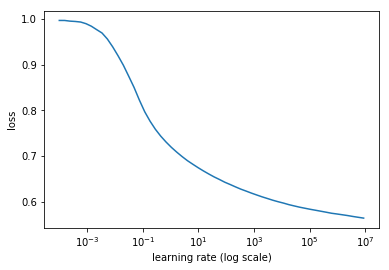

In [152]:
learn.sched.plot(n_skip=0, n_skip_end=40)

In [167]:
lr = 1e-2
wd = 1e-6

In [168]:
learn.precompute = True

In [169]:
learn.fit(lr, 1, cycle_len=20, wds=wd, use_clr=(20,10))

epoch      trn_loss   val_loss                             
    0      0.469284   0.367728  
    1      0.365951   0.318364                             
    2      0.315052   0.28285                              
    3      0.281834   0.263158                             
    4      0.26386    0.253882                             
    5      0.248928   0.243281                             
    6      0.237369   0.242201                             
    7      0.22945    0.241611                             
    8      0.223087   0.234046                             
    9      0.215849   0.235365                             
    10     0.209586   0.22575                              
    11     0.202116   0.22439                              
    12     0.197956   0.22328                              
    13     0.190919   0.220428                             
    14     0.187017   0.218564                             
    15     0.182995   0.216715                             
    16 

[0.20934649087764598]

In [170]:
learn.save('model1')

In [171]:
learn.load('model1')

## Searching images

### Searching for imagenet classes

In [218]:
class_ids, wordvecs = list(zip(*imagenet_id2wordvec))  # this gives <1k results

In [219]:
class_ids[:5], wordvecs[0].shape

(('n01440764', 'n01443537', 'n01494475', 'n01498041', 'n01514668'), (300,))

In [220]:
predicted_word_vecs = learn.predict()

In [221]:
len(predicted_word_vecs)

1404

In [222]:
start=0

In [223]:
denorm = modeldata.val_ds.denorm

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.axis('off')
    return ax

def show_imgs(ims, cols, figsize=None):
    fig,axes = plt.subplots(len(ims)//cols, cols, figsize=figsize)
    for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
    plt.tight_layout()

**Let's take a look at a few validation images:**

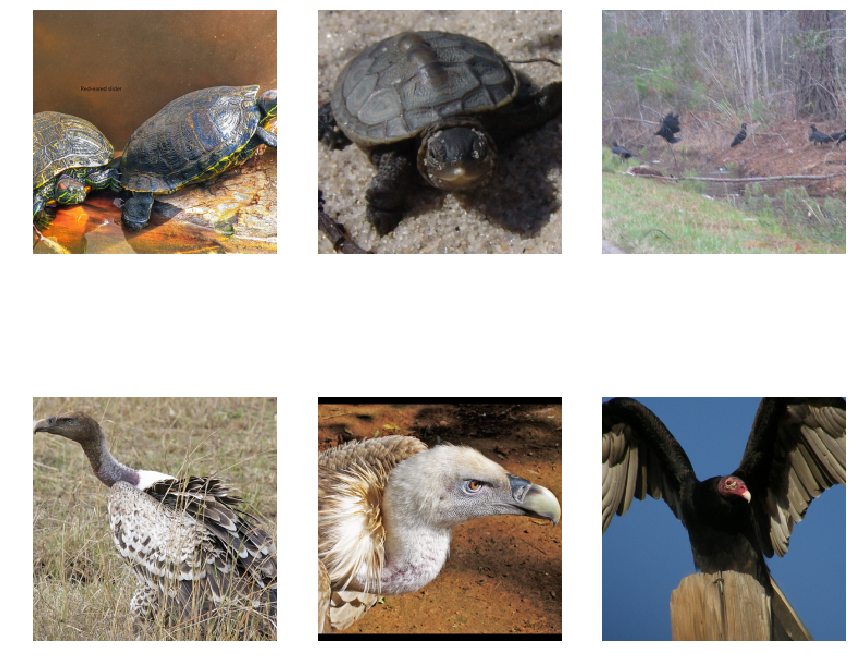

In [224]:
show_imgs(denorm(modeldata.val_ds[start:start+6][0]), 3, (12,12))

In [225]:
import nmslib  # nearest neighbours search library that is REALLY fast!!

In [226]:
def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

**The index is built from all the word vectors that belong to the Imagenet classes. Within this index we then find the nearest neighbours to our predicted wordvecs for an image.**

In [232]:
nearest_neighbour_index = create_index(wordvecs)

Given a vector `vec` (or several vectors `vecs`), these functions return the closest k vectors from the index:

In [228]:
def get_knn(index, vec):
    return index.knnQuery(vec, k=10)

In [229]:
def get_knns(index, vecs):
    return zip(*index.knnQueryBatch(vecs, k=10, num_threads=4))

Now we calculate the nearest neighbours of the predicted wordvectors of the images we just saw:

In [233]:
nn_indcs, dists = get_knns(nearest_neighbour_index, predicted_word_vecs)

These are the class names of the nearest neighbours of the predicted word vectors:

In [234]:
[[classIds_wordnet[class_ids[id]] for id in ids[:3]] for ids in nn_indcs[start:start+6]]

[['terrapin', 'loggerhead', 'diamondback'],
 ['terrapin', 'loggerhead', 'diamondback'],
 ['vulture', 'hyena', 'ostrich'],
 ['vulture', 'magpie', 'partridge'],
 ['vulture', 'ostrich', 'bustard'],
 ['vulture', 'magpie', 'oystercatcher']]

**This is pretty cool:**

1. 'terrapin', 'loggerhead', 'diamondback' are all turtle types
2. Apart from 'hyena' all other nearest neighbours are birds which also makes sense if you look at the pictures

### Search for all WordNet noun classes
The last try was to search the nearest neighbours of our predictions only from the <1k imagenet classes. Now we do the same but with all WordNet noun classes.

In [237]:
class_ids_wordnet, wordvecs_wordnet = list(zip(*wordnet_id2wordvec))  # This gives ~50k results

In [238]:
len(wordnet_id2wordvec)

49469

**The index is built from all the word vectors that belong to the WordNet classes. Within this index we then find the nearest neighbours to our predicted wordvecs for an image.**

In [239]:
nearest_neighbour_index_wordnet = create_index(wordvecs_wordnet)

In [240]:
nn_indcs, dists = get_knns(nearest_neighbour_index_wordnet, predicted_word_vecs)

In [241]:
[[classIds_wordnet[class_ids_wordnet[id]] for id in ids[:3]] for ids in nn_indcs[start:start+6]]

[['terrapin', 'turtle', 'Terrapene'],
 ['terrapin', 'turtle', 'Terrapene'],
 ['vulture', 'Vultur', 'ostrich'],
 ['vulture', 'Vultur', 'bird'],
 ['vulture', 'Vultur', 'Coragyps'],
 ['vulture', 'Vultur', 'stork']]

**Wow, this works just as well :D 'Coragyps' is a bird too apparently**

In [243]:
classIds_wordnet

{'n00001740': 'entity',
 'n00001930': 'physical_entity',
 'n00002137': 'abstraction',
 'n00002452': 'thing',
 'n00002684': 'object',
 'n00003553': 'whole',
 'n00003993': 'congener',
 'n00004258': 'living_thing',
 'n00004475': 'organism',
 'n00005787': 'benthos',
 'n00005930': 'dwarf',
 'n00006024': 'heterotroph',
 'n00006150': 'parent',
 'n00006269': 'life',
 'n00006400': 'biont',
 'n00006484': 'cell',
 'n00007347': 'causal_agent',
 'n00007846': 'person',
 'n00015388': 'animal',
 'n00017222': 'plant',
 'n00019046': 'native',
 'n00019128': 'natural_object',
 'n00019613': 'substance',
 'n00020090': 'substance',
 'n00020827': 'matter',
 'n00021265': 'food',
 'n00021734': 'nutrient',
 'n00021939': 'artifact',
 'n00022903': 'article',
 'n00023100': 'psychological_feature',
 'n00023271': 'cognition',
 'n00023773': 'motivation',
 'n00024264': 'attribute',
 'n00024720': 'state',
 'n00026192': 'feeling',
 'n00027167': 'location',
 'n00027807': 'shape',
 'n00028270': 'time',
 'n00028651': 'space

In [244]:
class_ids_wordnet

('n00001740',
 'n00002137',
 'n00002452',
 'n00002684',
 'n00003553',
 'n00003993',
 'n00004475',
 'n00005787',
 'n00005930',
 'n00006024',
 'n00006150',
 'n00006269',
 'n00006484',
 'n00007846',
 'n00015388',
 'n00017222',
 'n00019046',
 'n00019613',
 'n00020090',
 'n00020827',
 'n00021265',
 'n00021734',
 'n00021939',
 'n00022903',
 'n00023271',
 'n00023773',
 'n00024264',
 'n00024720',
 'n00026192',
 'n00027167',
 'n00027807',
 'n00028270',
 'n00028651',
 'n00029378',
 'n00029677',
 'n00030358',
 'n00031264',
 'n00031921',
 'n00032613',
 'n00033020',
 'n00033615',
 'n00034213',
 'n00034479',
 'n00034574',
 'n00034777',
 'n00034939',
 'n00035189',
 'n00035697',
 'n00035891',
 'n00036061',
 'n00036299',
 'n00036580',
 'n00036762',
 'n00037006',
 'n00037090',
 'n00037200',
 'n00037396',
 'n00038262',
 'n00039021',
 'n00039211',
 'n00039297',
 'n00039545',
 'n00039916',
 'n00039990',
 'n00040152',
 'n00040420',
 'n00040804',
 'n00040962',
 'n00041188',
 'n00041468',
 'n00041614',
 'n000

### Search text -> image
**Let's try to take a word from WordNet, get the wordvector from FastText. We then make an nearest neighbour index of all the predicted wordvecs of the validation dataset and find the nearest neighbours in this validation dataset to the word from WordNet:**

An index of all the **predicted** word vectors of the validation dataset:

In [245]:
predicted_word_vectors_index = create_index(predicted_word_vecs)

In [258]:
vec = wordvector_dict["boat"]

In [259]:
indcs, dists = get_knn(predicted_word_vectors_index, vec)

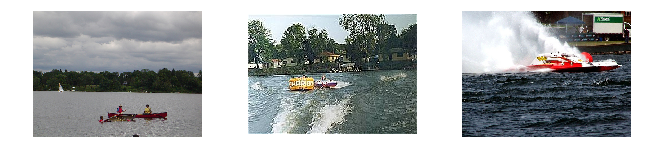

In [260]:
show_imgs([open_image(PATH/modeldata.val_ds.fnames[i]) for i in indcs[:3]], 3, figsize=(9,3));

**That looks like boats to me :) And the incredible thing is that 'boat' is not even an imagenet category. So the pretrained network has never classified these images as boats.**

**Can we also find results in the validation dataset (the wordvectors are predicted) by interpolating between the wordvectors of two words from WordNet (word vectors from FastText)??**

In [262]:
vec = (wordvector_dict['engine'] + wordvector_dict['boat'])/2

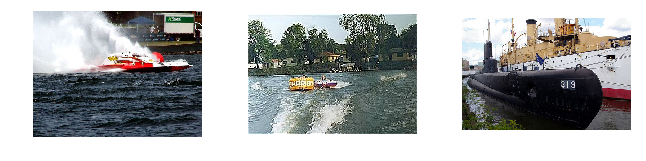

In [263]:
indcs, dists = get_knn(predicted_word_vectors_index, vec)
show_imgs([open_image(PATH/modeldata.val_ds.fnames[i]) for i in indcs[:3]], 3, figsize=(9,3));

In [264]:
vec = (wordvector_dict['sail'] + wordvector_dict['boat'])/2

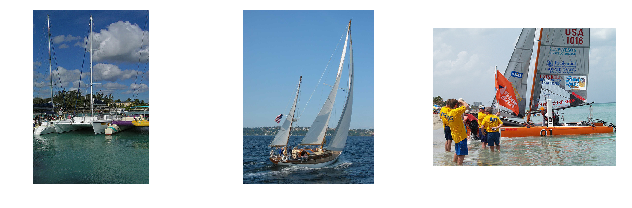

In [265]:
indcs, dists = get_knn(predicted_word_vectors_index, vec)
show_imgs([open_image(PATH/modeldata.val_ds.fnames[i]) for i in indcs[:3]], 3, figsize=(9,3));

**Wow, this actually works :) and neighter 'sail' or 'boat' are imagenet classes**

### Search image -> image
Take an image, predict the word vector and than find word vectors that are similar to this one:

In [309]:
fname = 'data/imagenet/train/n02091467/n02091467_1927.JPEG'

In [310]:
img = open_image(fname)

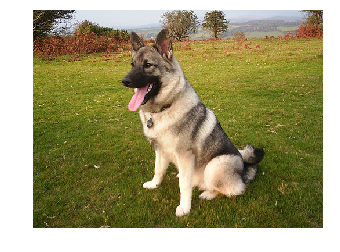

In [311]:
show_img(img)

In [312]:
transformed_img = modeldata.val_ds.transform(img)

In [317]:
transformed_img[None][0].shape

(3, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


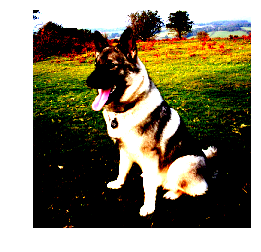

In [326]:
show_img(transformed_img[None][0].transpose(1,2,0))

In [335]:
learn.precompute = False

In [337]:
pred = learn.predict_array(transformed_img[None])

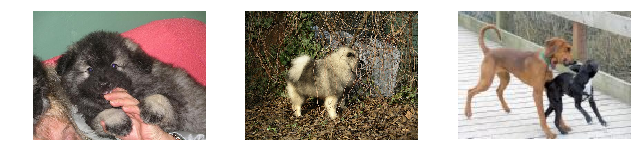

In [338]:
indcs, dists = get_knn(predicted_word_vectors_index, pred)
show_imgs([open_image(PATH/modeldata.val_ds.fnames[i]) for i in indcs[:3]], 3, figsize=(9,3));

**And these are dogs too :)**

## Summary
**We used three different kinds of searches now:**

1. Calculate the nearest neighbour index for all imagenet or wordnet class wordvecs (taken from FastText). Predict the wordvec for an image in the validation dataset. Find the nearest neighbours of this wordvec. This gives you class names from imagenet or wordnet for the specified image.
1. Calculate the nearest neighbour index of all the predicted wordvecs of the validation dataset and then find the nearest neighbours of a wordvec belonging to a word from WordNet (or an interpolation of wordvecs of words belonging to wordnet). You specify a string and get an image.
1.  Calculate the nearest neighbour index of all the predicted wordvecs of the validation dataset. Predict a wordvec for an image and then find other images from the validation dataset that have similar predicted wordvecs.